## Run the below code cell.


In [3]:
!wget "https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip"
!wget "https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG16Data.npz"

--2018-10-23 20:35:00--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.20.1
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.20.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  26.5MB/s    in 42s     

2018-10-23 20:35:42 (25.7 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

--2018-10-23 20:35:42--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG16Data.npz
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.24.105
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.24.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 850230376 (811M) [application/x-www-form-urlencoded]
Saving to: ‘DogVGG16Data.npz’

DogVGG16Dat


## Run the below code cell

In [ ]:
!unzip "dogImages.zip"

In [5]:
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# %matploltib inline

import IPython
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
from keras.preprocessing import image as keras_image     
from tqdm import tqdm
from PIL import ImageFile
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential
from keras import optimizers

In [2]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    print("dog_files", dog_files)
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [77]:
def plotting_data_generator(target_ndarray, ground_truth_array):
    d = {}
    for i in range(len(target_ndarray)):
        key = np.argmax(target_ndarray[i])
        value = d.get(ground_truth_array[key], 0)
        d[ground_truth_array[key]] = value + 1
    return d

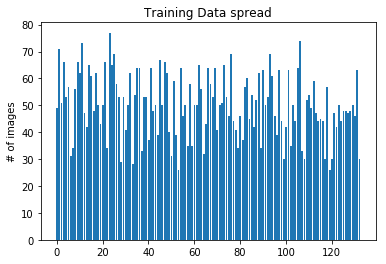

In [47]:
training_plot_data = plotting_data_generator(train_targets, dog_names)
train_categories_values = list(training_plot_data.values())
xs = [i + 0.1 for i, _ in enumerate(dog_names)]
plt.bar(xs, train_categories_values)
plt.ylabel("# of images")
plt.title("Training Data spread")
plt.show()
# plt.xticks([i+ 100.5 for i, _ in enumerate(dog_names)], dog_names)

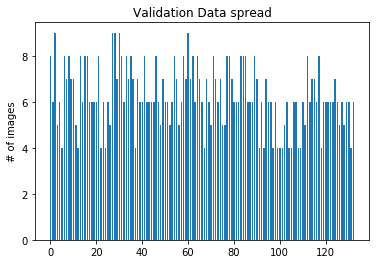

In [93]:
validation_plot_data = plotting_data_generator(valid_targets, dog_names)
valid_categories_values = list(validation_plot_data.values())

xs = [i + 0.1 for i, _ in enumerate(dog_names)]
width = 0.65
plt.bar(xs, valid_categories_values,width)
plt.ylabel("# of images")
plt.title("Validation Data spread")
plt.show()


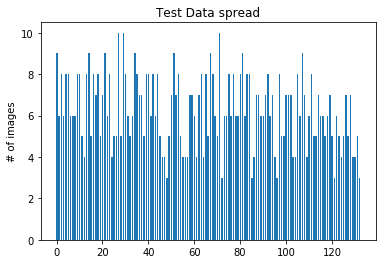

In [92]:
testing_plot_data = plotting_data_generator(test_targets, dog_names)
test_categories_values = list(testing_plot_data.values())

xs = [i+0.1 for i, _ in enumerate(dog_names)]
width = 0.65
p1 = plt.bar(xs, test_categories_values,width)
plt.ylabel("# of images")
plt.title("Test Data spread")
plt.show()

In [3]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = keras_image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = keras_image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [4]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:05<00:00, 144.48it/s]


(6680, 224, 224, 3)

In [100]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=3, strides=1, input_shape=[224, 224, 3], padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2, strides=2, padding="same"))
model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=2, strides=2, padding="same"))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=2, strides=2, padding="same"))
model.add(GlobalAveragePooling2D())
model.add(Dense(units=133,activation="softmax"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 64)                0         
__________

In [101]:

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
if not os.path.isdir("saved_models"):
    os.mkdir("saved_models")
    
epochs = 20

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

history_of_model = model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=32, callbacks=[checkpointer], verbose=1)



In [105]:

history_of_model.history.keys()

NameError: name 'history_of_model' is not defined

In [ ]:

plt.plot(history_of_model.history['acc'])
plt.plot(history_of_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:

plt.plot(history_of_model.history['acc'])
plt.plot(history_of_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
if not os.path.isdir("saved_models"):
    os.mkdir("saved_models")
    
epochs = 20

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

history_of_model = model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=32, callbacks=[checkpointer], verbose=1)



Train on 6680 samples, validate on 835 samples
Epoch 1/20
1728/6680 [======>.......................] - ETA: 29:19 - loss: 4.8894 - acc: 0.0093

In [ ]:

plt.plot(history_of_model.history['acc'])
plt.plot(history_of_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
if not os.path.isdir("saved_models"):
    os.mkdir("saved_models")
    
epochs = 20

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

history_of_model = model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=32, callbacks=[checkpointer], verbose=1)



Train on 6680 samples, validate on 835 samples
Epoch 1/20
1728/6680 [======>.......................] - ETA: 29:19 - loss: 4.8894 - acc: 0.0093

In [ ]:

plt.plot(history_of_model.history['acc'])
plt.plot(history_of_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [8]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

In [9]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 5.8612%


We can see that the testing accuracy is abyssmal and achieves ~6%.

In order for the model to perform better, lets try to use existing models, specifically VGG16 which is pretrained on the 
ImageNet dataset.

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model. We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

# Transfer Learning 

In [9]:
bottleneck_features = np.load('DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

In [10]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


## Compile the model 

In [11]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

## Train the model

In [14]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 0s 73us/step - loss: 12.2851 - acc: 0.1192 - val_loss: 10.4116 - val_acc: 0.2263

Epoch 00001: val_loss improved from inf to 10.41157, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 2/20
6680/6680 [==============================] - 0s 57us/step - loss: 9.6821 - acc: 0.2921 - val_loss: 9.4443 - val_acc: 0.3174

Epoch 00002: val_loss improved from 10.41157 to 9.44432, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 3/20
6680/6680 [==============================] - 0s 56us/step - loss: 9.0769 - acc: 0.3614 - val_loss: 9.0775 - val_acc: 0.3545

Epoch 00003: val_loss improved from 9.44432 to 9.07748, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 4/20
6680/6680 [==============================] - 0s 57us/step - loss: 8.6511 - acc: 0.3996 - val_loss: 8.9534 - val_acc: 0.3473

Epoch 00004: val_loss improved from 9.07748 to 8.95341, saving model to saved_mode

### Load the Model with the Best Validation Loss

In [ ]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the model accuracy

In [16]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
vgg_test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 46.4115%


We see that we are able to achieve 50% accuracy using VGGNET16 that was pre-trained on the ImageNet dataset.

#### Reason: 
Imagenet dataset contains a lot of dog categories and images and naturally is able to better extract the features.

Also, one important thing to note is that, VGGNet16 is a deep Neural Network architecture than the model we had created( so it is able to better classify the dogs and hence much better accuracy).

Another thing to note is that human level accuracy would also amount around 50-70% because of the huge variety in the number of dogs in the dataset.

#### 133 Classes

### Predict Dog Breed with the Model

In [17]:
def extract_VGG16(tensor):
    from keras.applications.vgg16 import VGG16, preprocess_input
    return VGG16(weights="imagenet",include_top = False).predict(preprocess_input(tensor))

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

def predictions(path):
    
    return VGG16_predict_breed(path)

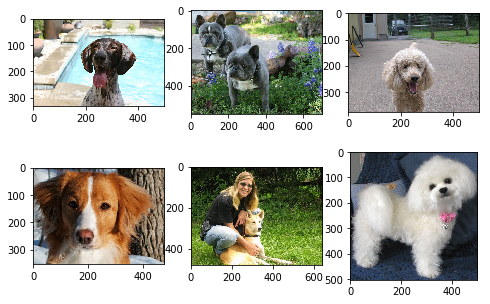

In [14]:
cols = 3
rows = 3
i = 1
filepath = "dogImages/test/"
fig=plt.figure(figsize=(8, 8))
for filename in os.listdir(filepath):
    img_path = filepath + filename
    image = np.random.choice(os.listdir(img_path))
    img_path += "/" + image
    dog_name = predictions(img_path)
    print("Actual dog breed: ", image[:-10] , ", Predicted dog breed: ", dog_name)
    img = mpimg.imread(img_path)

    fig.add_subplot(rows, cols, i)

    plt.imshow(img)
    i += 1
    if i == 7:
        break
plt.show()

In [95]:
model_name = ["own-model", "VGGNet16"]
accuracy_scores = [test_accuracy, vgg_test_accuracy]

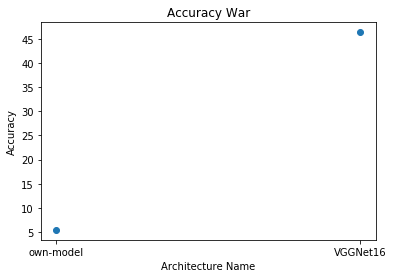

In [98]:
plt.scatter(model_name, accuracy_scores)
plt.title("Accuracy War")
plt.ylabel("Accuracy")
plt.xlabel("Architecture Name")
plt.show()